In [15]:
# Import libraries

import pandas as pd
import numpy as np
import random as rnd
import sklearn as skl
import seaborn as sn
import matplotlib.pyplot as plt
import sympy as sp
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import chi2_contingency
import warnings
from IPython.display import display, Math
from pickle import dump

warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.3f}'.format
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

In [ ]:
# Import data
url = "https://breathecode.herokuapp.com/asset/internal-link?id=437&path=heads/main/winequality-red.csv"
dfRedWineQual_raw = pd.read_csv(url, sep=';')

In [17]:
# Data inspection

print(dfRedWineQual_raw.shape)
print(dfRedWineQual_raw.info())

# Verify duplicates and NANs

if dfRedWineQual_raw.duplicated().any().any():
    dfRedWineQual_raw = dfRedWineQual_raw.drop_duplicates()

if dfRedWineQual_raw.isna().any().any():
    dfRedWineQual_raw = dfRedWineQual_raw.dropna()

(1599, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [18]:
# Creating a dictionary to map quality scores to labels

quality_rescale = {3: 0, 4: 0, 5: 1, 6: 1, 7: 2, 8: 2}
dfRedWineQual_processed = dfRedWineQual_raw.drop('quality', axis=1)
dfRedWineQual_processed['quality'] = dfRedWineQual_raw['quality'].map(quality_rescale)

quality_labels = {0: 'low', 1: 'medium', 2: 'high'}
dfRedWineQual_processed['quality_label'] = dfRedWineQual_processed['quality'].map(quality_labels)

# Reset index after cleaning data
dfRedWineQual_processed = dfRedWineQual_processed.reset_index(drop=True)

In [ ]:
# Balancing the dataset by downsampling the 'medium' quality wines
indices0 = dfRedWineQual_processed.index[dfRedWineQual_processed['quality_label'] == 'low'].tolist()
indices1 = dfRedWineQual_processed.index[dfRedWineQual_processed['quality_label'] == 'medium'].tolist()
indices2 = dfRedWineQual_processed.index[dfRedWineQual_processed['quality_label'] == 'high'].tolist()

n1 = 600 # Number of elements to pick
n2 = 150 # Number of elements to pick

# Select n unique random numbers
indices1_unique  = rnd.sample(indices1, n1)
indices2_unique  = rnd.sample(indices2, n2)
indices_total    = np.concatenate((indices0, indices1_unique, indices2_unique))
indices_total.sort()
dfRedWineQual_new = dfRedWineQual_processed.iloc[indices_total].copy()
dfRedWineQual_new['quality_label'].value_counts()

quality_label
medium    600
high      184
low        63
Name: count, dtype: int64

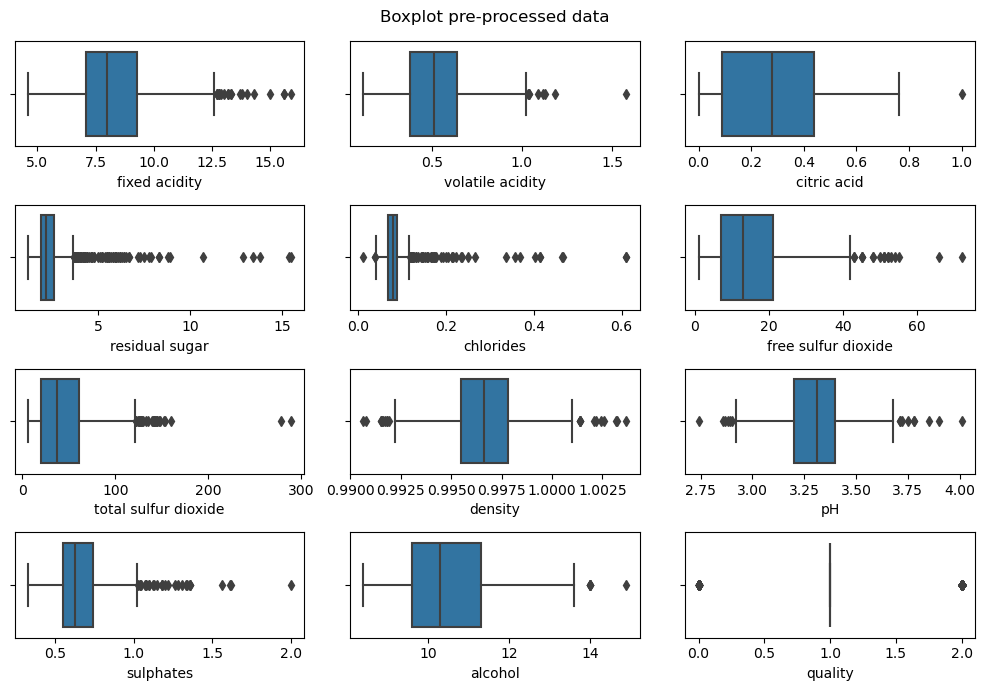

In [20]:
# Exploratory data analysis

# Get outliers
fig, axis = plt.subplots(4,3,figsize=(10,7))
r = 0
c = 0
for col_name in dfRedWineQual_new.drop('quality_label', axis=1).columns:
    sn.boxplot(ax=axis[r,c], data = dfRedWineQual_new, x = dfRedWineQual_new[col_name])
    c += 1
    if c > 2:
        r += 1
        c = 0

plt.suptitle('Boxplot pre-processed data')
plt.tight_layout()
plt.show()


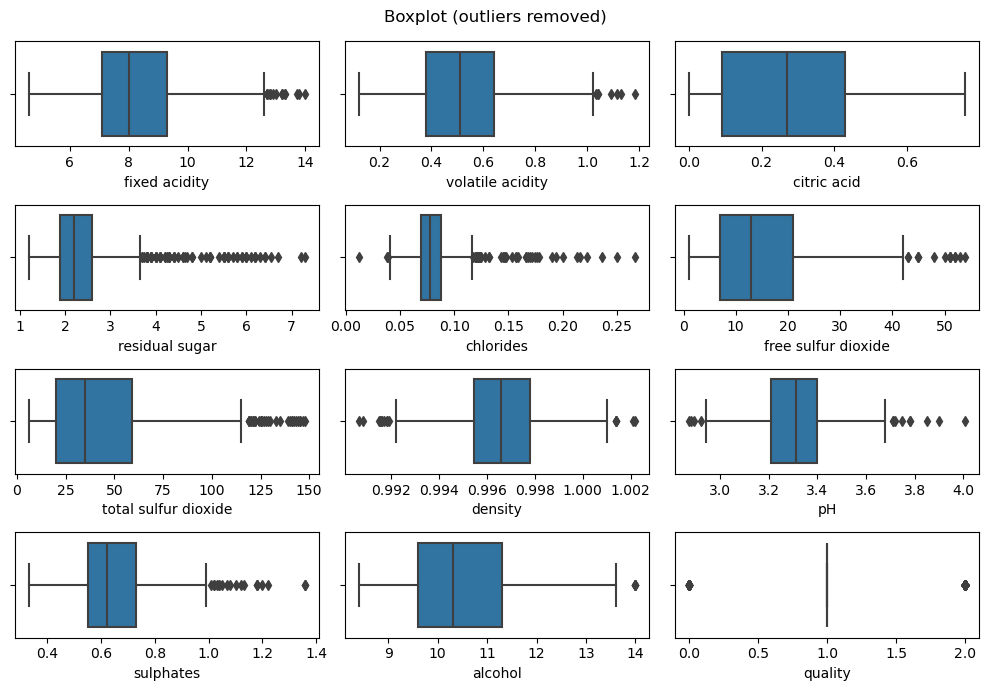

In [21]:
# Remove some of the outliers

dfRedWineQual_new = dfRedWineQual_new[dfRedWineQual_new['fixed acidity'] <= 14]
dfRedWineQual_new = dfRedWineQual_new[dfRedWineQual_new['volatile acidity'] <= 1.25]
dfRedWineQual_new = dfRedWineQual_new[dfRedWineQual_new['residual sugar'] <= 7.5]
dfRedWineQual_new = dfRedWineQual_new[dfRedWineQual_new['chlorides'] <= 0.3]
dfRedWineQual_new = dfRedWineQual_new[dfRedWineQual_new['free sulfur dioxide'] <= 60]
dfRedWineQual_new = dfRedWineQual_new[dfRedWineQual_new['total sulfur dioxide'] <= 150]
dfRedWineQual_new = dfRedWineQual_new[dfRedWineQual_new['sulphates'] <= 1.5]
dfRedWineQual_new = dfRedWineQual_new[dfRedWineQual_new['alcohol'] <= 14]

fig, axis = plt.subplots(4,3,figsize=(10,7))
r = 0
c = 0
for col_name in dfRedWineQual_new.drop(columns=['quality_label']).columns:
    sn.boxplot(ax=axis[r,c], data = dfRedWineQual_new, x = dfRedWineQual_new[col_name])
    c += 1
    if c > 2:
        r += 1
        c = 0

plt.suptitle('Boxplot (outliers removed)')
plt.tight_layout() 
plt.show()  


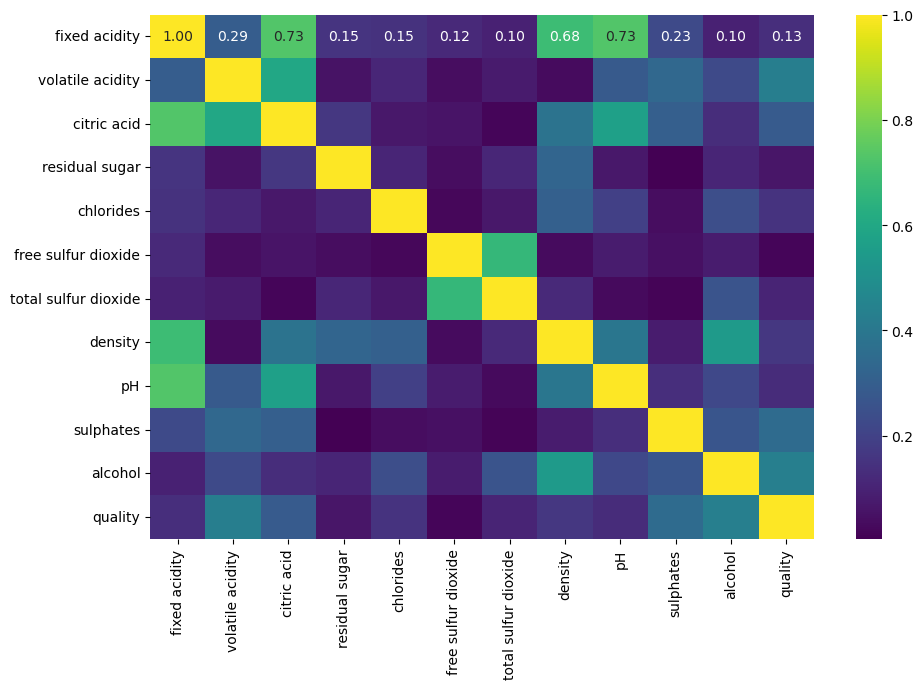

In [23]:
# Get correlation matrix

fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(dfRedWineQual_new.drop(columns=['quality_label']).corr(method="pearson").abs(), annot=True, annot_kws={"fontsize": 10}, fmt=".2f", cmap="viridis", ax=ax)
plt.tight_layout()
plt.show()

In [24]:
# Normalized features with min-max normalization due to KNN sensitivity to feature scales
X = dfRedWineQual_new.drop(['quality_label','quality','fixed acidity', 'free sulfur dioxide'], axis=1)
Xnorm = (X - X.min())/(X.max() - X.min())

# Target variable
y = dfRedWineQual_new['quality']

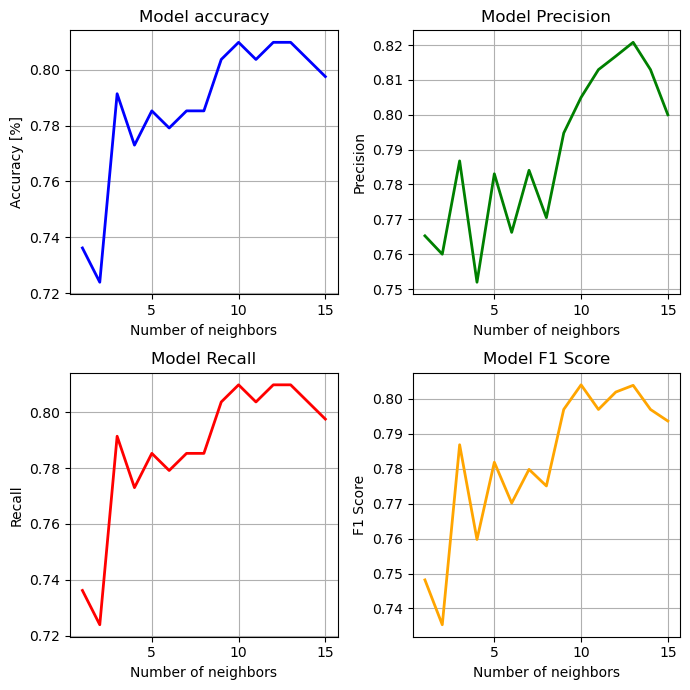

In [25]:
## Check best number of clusters for the model

# Split data

X_train, X_test, y_train, y_test = train_test_split(Xnorm, y, random_state = 42, train_size = 0.8)

accuracy  = []
precision = []
recall    = []
f1        = []
k_range = range(1,16)

for k in k_range:

    # K-Nearest Neighbors Classifier

    redwine_model = KNeighborsClassifier(n_neighbors=k) 
    redwine_model.fit(X_train, y_train)

    # Perform prediction
    y_pred = redwine_model.predict(X_test)

    # Compute accuracy, precision, and recall
    accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test, y_pred, average='weighted'))
    recall.append(recall_score(y_test, y_pred, average='weighted'))
    f1.append(f1_score(y_test, y_pred, average='weighted'))

# Plot split vs. scores

fig, ax = plt.subplots(2,2,figsize=(7,7))

ax[0,0].plot(k_range,accuracy,color='blue',linewidth=2)
ax[0,0].grid()
ax[0,0].set_xlabel("Number of neighbors")
ax[0,0].set_ylabel("Accuracy [%]")
ax[0,0].set_title("Model accuracy")

ax[0,1].plot(k_range,precision,color='green',linewidth=2)
ax[0,1].grid()
ax[0,1].set_xlabel("Number of neighbors")
ax[0,1].set_ylabel("Precision")
ax[0,1].set_title("Model Precision")

ax[1,0].plot(k_range,recall,color='red',linewidth=2)
ax[1,0].grid()
ax[1,0].set_xlabel("Number of neighbors")
ax[1,0].set_ylabel("Recall")
ax[1,0].set_title("Model Recall")

ax[1,1].plot(k_range,f1,color='orange',linewidth=2)
ax[1,1].grid()
ax[1,1].set_xlabel("Number of neighbors")
ax[1,1].set_ylabel("F1 Score")
ax[1,1].set_title("Model F1 Score")
plt.tight_layout()



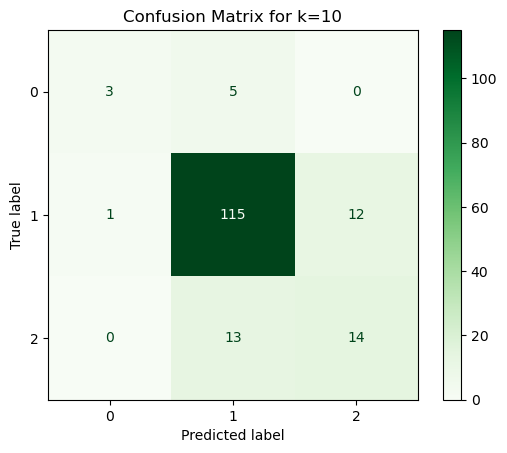

In [31]:
# Confusion matrix for the best k
best_k = k_range[np.argmax(f1)]
redwine_model = KNeighborsClassifier(n_neighbors=best_k) 
redwine_model.fit(X_train, y_train)
y_pred = redwine_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=redwine_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=redwine_model.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title(f'Confusion Matrix for k={best_k}')
plt.show()


In [27]:
# Classification report
print(f'Classification Report for k={best_k}:\n')
print(classification_report(y_test, y_pred))

Classification Report for k=10:

              precision    recall  f1-score   support

           0       0.75      0.38      0.50         8
           1       0.86      0.90      0.88       128
           2       0.54      0.52      0.53        27

    accuracy                           0.81       163
   macro avg       0.72      0.60      0.64       163
weighted avg       0.81      0.81      0.80       163



In [32]:
## Save the model
dump(redwine_model, open("redwine_model_k_neighbors_cluster.sav", "wb"))

The K-neigbors model classifies category 0: low quality with uncertainty because of the small sample of data points. The accuracy, albeit reasonably good, is a misleading metric to assess due to the fact that the category 1: medium is far more common than the other two. Therefore, the model is tremendously biased towards the category 1: medium. The macro average of the f1 score is rather low, but the weighted one is high; this difference is due to the low number of category 0: low data points, which contribute less to the weighted average.

In the following, we will perform an hyperparameter optimization changing the number of neighbors and the distance metric used, as well as optimize for an f1 score, to verify whether the classification model can improve. Otherwise, we will reduce the number of samples for the categories 1 and 2 to balance the classification. If these two approaches fail, the former model will be the chosen one

In [29]:
hyperparams = {
    "n_neighbors": range(3,15),
    "weights": ['uniform', 'distance'],
    "metric": ['euclidean', 'manhattan', 'minkowski']
    
}

# We initialize the grid
grid = GridSearchCV(redwine_model, hyperparams, scoring = 'f1', cv = 5)
grid.fit(X_train, y_train)

# Get best parameters
print(f"Best hyperparameters: {grid.best_params_}")

# Test best hyperparameter combination

redwine_model = KNeighborsClassifier(**grid.best_params_)
redwine_model.fit(X_train, y_train)
y_pred = redwine_model.predict(X_test)

# Compute accuracy, precision, and recall
grid_accuracy   = accuracy_score(y_test, y_pred)
grid_precision  = precision_score(y_test, y_pred, average='weighted')
grid_recall     = recall_score(y_test, y_pred, average='weighted')
grid_f1         = f1_score(y_test, y_pred, average='weighted')

print('The best linear regression model to predict the health factor uses the following independent variables\n')
for i, col in enumerate(X.columns):
    print(f'{i+1}. {col}')
print('\n')

print(f'The linear regression after processing the data has the following performance parameters:\n')
print(f'Accuracy = {grid_accuracy:0.3f}')
print(f'Precision = {grid_precision:0.3f}')
print(f'Recall = {grid_recall:0.3f}')
print(f'F1 Score = {grid_f1:0.3f}\n')

Best hyperparameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
The best linear regression model to predict the health factor uses the following independent variables

1. volatile acidity
2. citric acid
3. residual sugar
4. chlorides
5. total sulfur dioxide
6. density
7. pH
8. sulphates
9. alcohol


The linear regression after processing the data has the following performance parameters:

Accuracy = 0.791
Precision = 0.787
Recall = 0.791
F1 Score = 0.787



In [30]:
# Classification report
print(f'Classification Report for k={best_k}:\n')
print(classification_report(y_test, y_pred))

Classification Report for k=10:

              precision    recall  f1-score   support

           0       0.50      0.25      0.33         8
           1       0.86      0.88      0.87       128
           2       0.52      0.56      0.54        27

    accuracy                           0.79       163
   macro avg       0.63      0.56      0.58       163
weighted avg       0.79      0.79      0.79       163



This model does not exhibit better metrics than the previous one. Therefore, the selected prediction model is the first one developed.